# Goodwin's oscillator toy model

This example shows how the Goodwin's Oscillator toy model can be used.

Our version of this model has five parameters and three oscillating states as described in [1].

[1] Estimating Bayes factors via thermodynamic integration and population MCMC. Ben Calderhead and Mark Girolami, 2009, Computational Statistics and Data Analysis.

We start by creating a toy model:

In [1]:
import pints
import pints.plot
import pints.toy
import matplotlib.pyplot as plt
import numpy as np

In [2]:
model = pints.toy.GoodwinOscillatorModel()

The model also provides suggested parameters and sampling times, allowing us to run a simulation:

In [3]:
real_parameters = model.suggested_parameters()
times = model.suggested_times()
values = model.simulate(real_parameters, times)

This gives us all we need to create a plot of current versus time:

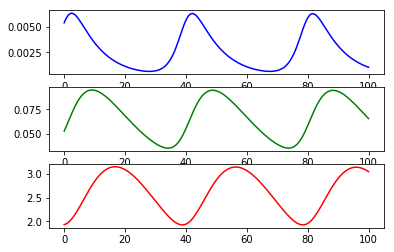

In [4]:
plt.figure()
plt.subplot(3, 1, 1)
plt.plot(times, values[:, 0], 'b')
plt.subplot(3, 1, 2)
plt.plot(times, values[:, 1], 'g')
plt.subplot(3, 1, 3)
plt.plot(times, values[:, 2], 'r')
plt.show()

Now we will add some noise to generate some fake "experimental" data and try to recover the original parameters.

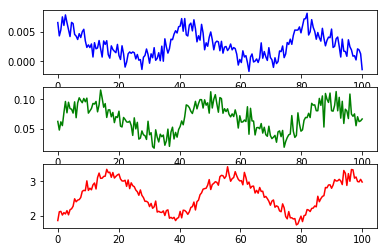

In [5]:
noise1 = 0.001
noise2 = 0.01
noise3 = 0.1
noisy_values = np.array(values, copy=True)
noisy_values[:, 0] += np.random.normal(0, noise1, len(times))
noisy_values[:, 1] += np.random.normal(0, noise2, len(times))
noisy_values[:, 2] += np.random.normal(0, noise3, len(times))

plt.figure()
plt.subplot(3, 1, 1)
plt.plot(times, noisy_values[:, 0], 'b')
plt.subplot(3, 1, 2)
plt.plot(times, noisy_values[:, 1], 'g')
plt.subplot(3, 1, 3)
plt.plot(times, noisy_values[:, 2], 'r')
plt.show()

Now we can try and infer the original parameters:

In [6]:
# Create an object with links to the model and time series
problem = pints.MultiOutputProblem(model, times, values)

# Create a log posterior
log_prior = pints.UniformLogPrior([1, 1, 0.01, 0.01, 0.01], [10, 10, 1, 1, 1])
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, [noise1, noise2, noise3])
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Run MCMC on the noisy data
x0 = [[5, 5, 0.5, 0.5, 0.5]]*3
mcmc = pints.MCMCController(log_posterior, 3, x0)
mcmc.set_max_iterations(5000)
mcmc.set_log_to_screen(False)

print('Running')
chains = mcmc.run()
print('Done!')

Running
Done!


We can use an MCMCSummary to display the results:

In [7]:
results = pints.MCMCSummary(
    chains=chains, 
    time=mcmc.time(),
    parameter_names=['k2', 'k3', 'm1', 'm2', 'm3']
)
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess    ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -----  --------------
k2       2.79    1.32    1.51    1.80   2.05   4.41   5.38     1.67    14.71  0.18
k3       4.24    1.11    1.97    3.85   4.26   4.83   6.03     2.01    17.52  0.21
m1       0.18    0.12    0.09    0.10   0.12   0.20   0.52     1.22    14.57  0.18
m2       0.09    0.07    0.03    0.07   0.08   0.09   0.18     1.05    49.56  0.60
m3       0.10    0.04    0.05    0.09   0.10   0.12   0.18     1.29    48.83  0.59


Now we can inspect the resulting chains:

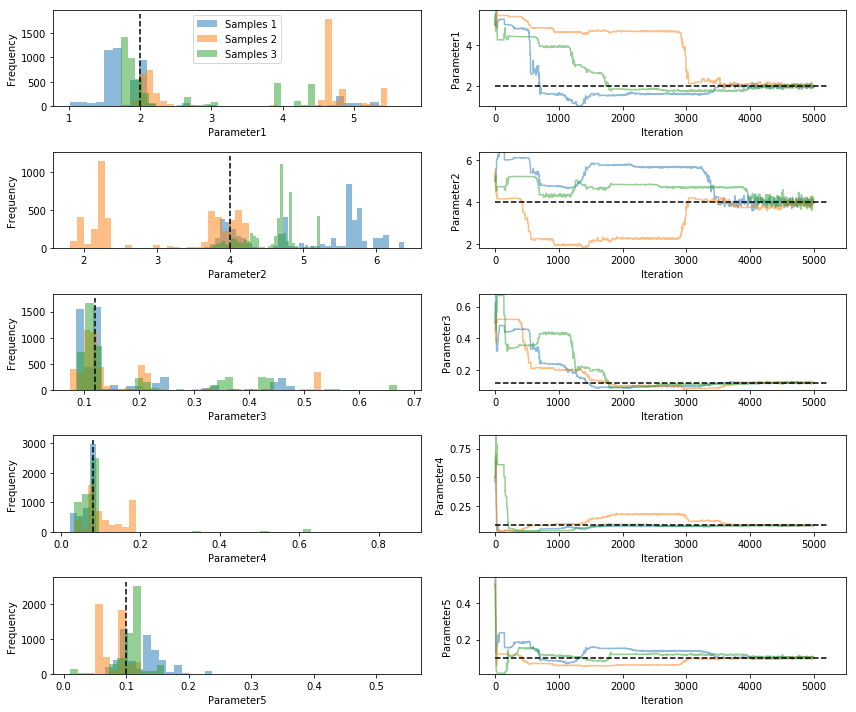

In [8]:
pints.plot.trace(chains, ref_parameters=real_parameters)
plt.show()

This is a pretty hard problem!

And what about optimisation?

In [9]:
# Fit to the noisy data
parameters = []
opt = pints.OptimisationController(log_posterior, x0[0], method=pints.XNES)
opt.set_log_to_screen(False)
parameters, fbest = opt.run()

print('')
print('            p1       p2       p3       p4       p5')
print('real  ' + ' '.join(['{: 8.4g}'.format(float(x)) for x in real_parameters]))
print('found ' + ' '.join(['{: 8.4g}'.format(x) for x in parameters]))


            p1       p2       p3       p4       p5
real         2        4     0.12     0.08      0.1
found    1.999    4.002     0.12  0.07998      0.1


## Sampling using relativistic HMC

The Goodwin-oscillator model has sensitivities calculated by the forward sensitivities approach, so we can use samplers that use gradients (although they will be slower per iteration; although perhaps not by ESS per second!), like Relativistic HMC.

In [10]:
problem = pints.MultiOutputProblem(model, times, noisy_values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0, 0, 0, 0, 0, 0, 0, 0],
    [10, 10, 1, 1, 1, 1, 1, 1]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
real_parameters1 = np.array(real_parameters.tolist() + [noise1, noise2, noise3])
xs = [
    real_parameters1 * 1.1,
    real_parameters1 * 0.9,
    real_parameters1 * 1.15,
    real_parameters1 * 1.2,
]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 4, xs, method=pints.RelativisticMCMC)

# Add stopping criterion
mcmc.set_max_iterations(200)

# Run in parallel
mcmc.set_parallel(True)
mcmc.set_log_interval(1)

# Tune the samplers' hyper-parameters
for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size([0.1, 0.5, 0.002, 0.002, 0.002, 0.0005, 0.001, 0.01])
    sampler.set_leapfrog_steps(10)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
Using Relativistic MCMC
Generating 4 chains.
Running in parallel with 4 worker processess.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.1
1     44     0.333     0.333     0.333     0.333      0:01.1
2     84     0.5       0.5       0.5       0.5        0:02.3
3     124    0.6       0.6       0.6       0.6        0:03.3
4     164    0.667     0.667     0.667     0.5        0:04.3
5     204    0.571     0.714     0.571     0.429      0:05.3
6     244    0.5       0.625     0.625     0.375      0:06.2
7     284    0.444     0.556     0.667     0.444      0:07.2
8     324    0.4       0.6       0.7       0.4        0:08.1
9     364    0.364     0.545     0.727     0.364      0:09.1
10    404    0.417     0.583     0.75      0.333      0:10.1
11    444    0.462     0.538     0.769     0.385      0:11.0
12    484    0.429     0.5       0.714     0.429      0:12.0
13    524    0.467     0.467     0.667     0

132   5284   0.701     0.552     0.716     0.582      2:08.5
133   5324   0.704     0.548     0.719     0.585      2:09.5
134   5364   0.699     0.544     0.721     0.588      2:10.4
135   5404   0.701     0.540146  0.723     0.584      2:11.4
136   5444   0.703     0.543     0.725     0.587      2:12.4
137   5484   0.705036  0.54      0.727     0.59       2:13.4
138   5524   0.707     0.543     0.729     0.593      2:14.4
139   5564   0.702     0.546     0.73      0.596      2:15.4
140   5604   0.704     0.542     0.725     0.592      2:16.4
141   5644   0.699     0.538     0.727     0.587      2:17.3
142   5684   0.701     0.535     0.729     0.59       2:18.3
143   5724   0.697     0.537931  0.731     0.593      2:19.3
144   5764   0.699     0.541     0.726     0.596      2:20.2
145   5804   0.701     0.544     0.728     0.592      2:21.2
146   5844   0.703     0.547     0.722973  0.588      2:22.1
147   5884   0.704698  0.55      0.718     0.584      2:23.1
148   5924   0.707     0

Display the results:

In [11]:
results = pints.MCMCSummary(
    chains=chains, 
    time=mcmc.time(),
    parameter_names=['k2', 'k3', 'm1', 'm2', 'm3', 'sigma_x', 'sigma_y', 'sigma_z'])
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
k2       2.07    0.09    1.94    2.02   2.06   2.12   2.24     1.11    72.79   0.38
k3       3.90    0.17    3.59    3.79   3.90   3.98   4.22     1.15    41.53   0.21
m1       0.12    0.00    0.12    0.12   0.12   0.12   0.13     1.07    58.82   0.30
m2       0.08    0.00    0.08    0.08   0.08   0.08   0.09     1.11    61.35   0.32
m3       0.10    0.00    0.09    0.10   0.10   0.10   0.11     1.20    33.24   0.17
sigma_x  0.00    0.00    0.00    0.00   0.00   0.00   0.00     1.02    220.39  1.14
sigma_y  0.01    0.00    0.01    0.01   0.01   0.01   0.01     1.01    173.95  0.90
sigma_z  0.10    0.01    0.09    0.10   0.10   0.10   0.14     1.04    134.45  0.69


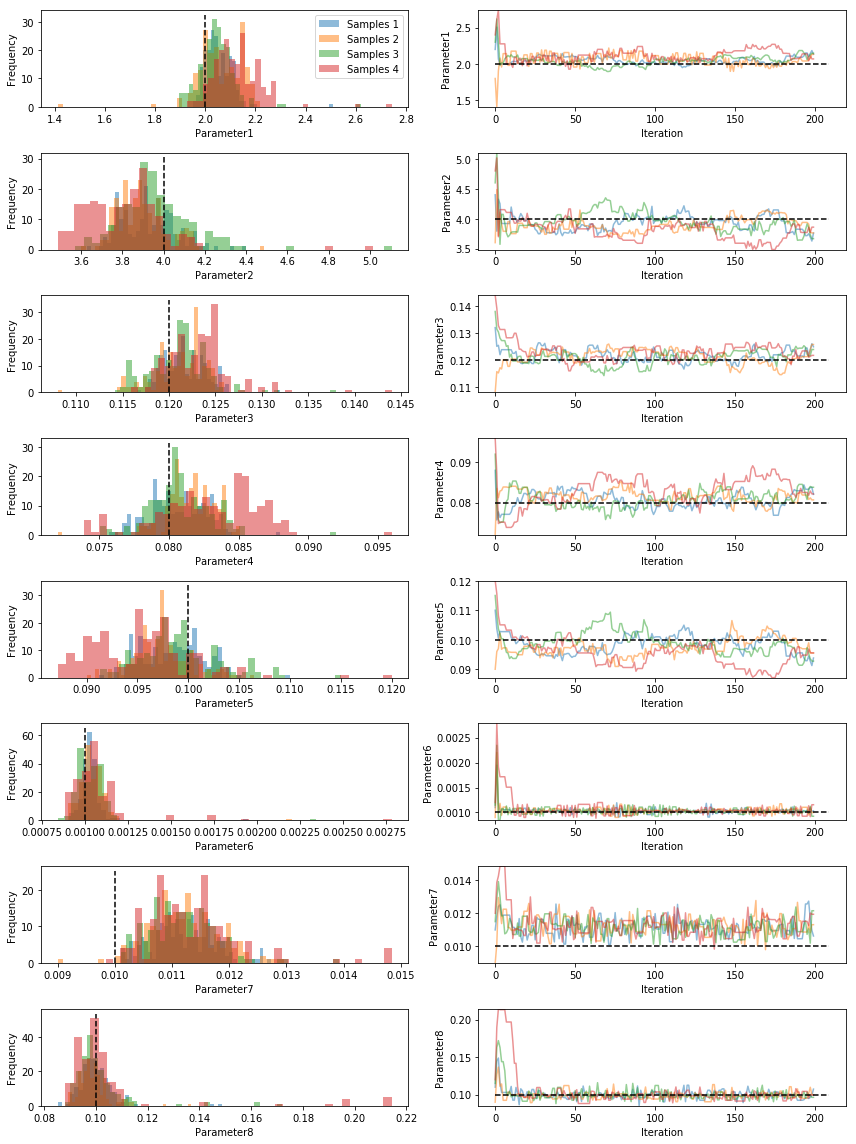

In [12]:
pints.plot.trace(chains, ref_parameters=real_parameters1)
plt.show()

Plot posterior predictive distribution.

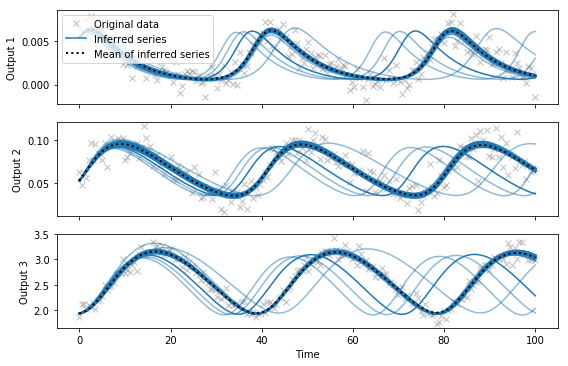

In [13]:
pints.plot.series(np.vstack(chains), problem)
plt.show()